>**This has recently been reworked to include a great suggestion from Tyler to weight the "mode" variable since the cluster shapes are very similar.**


Howdy. Here's a rundown of the file you're looking at. The cell immediately beneath does preprocessing on the data: variables get scaled 0-1, and major and minor keys get split up (we can still talk about this!) This will result in 2 sets of models. For this first set, I am only going to focus on major key songs (mode==1). This results in about 6500 songs being analyzed. 

In [184]:
#get the data
import pandas as pd
songs = pd.read_csv('test_songs.csv')

#preprocessing
from sklearn.preprocessing import StandardScaler
import numpy as np

info_cols = ['song_id','artist_name', 'album_name', 'artist_id', 'album_id']
X = songs.drop(songs[info_cols], axis=1)
(N,p) = X.shape

X["loudness_scaled"] = X.loudness.apply(lambda x: (x - np.min(X.loudness))/(np.max(X.loudness) - np.min(X.loudness)))
X["tempo_scaled"] = X.tempo.apply(lambda x: (x-np.min(X.tempo))/ (np.max(X.tempo) - np.min(X.tempo)))
X["key_scaled"] = X.key.apply(lambda x: (x-np.min(X.key))/ (np.max(X.key) - np.min(X.key)))
X["mode_weighted"] = X["mode"].apply(lambda x: x/p)
X_scaled = X.drop(["loudness", "tempo", "key", "mode"], axis=1) 
# X_major = X_scaled[X_scaled['mode']==1]
# X_major = X_major.drop("mode",axis=1)
# X_minor = X_scaled[X_scaled['mode']==0]
# X_minor = X_minor.drop("mode",axis=1)

In [185]:
X_scaled.head()

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,loudness_scaled,tempo_scaled,key_scaled,mode_weighted
0,0.754,0.635,0.0702,0.03260,0.03370,0.1080,0.476,0.801953,0.545836,0.545455,0.000000
1,0.736,0.924,0.1340,0.00991,0.01050,0.1110,0.771,0.803751,0.555088,0.090909,0.090909
2,0.786,0.724,0.1340,0.01270,0.00472,0.2210,0.358,0.797723,0.546013,0.636364,0.090909
3,0.586,0.817,0.0545,0.05430,0.95700,0.1190,0.194,0.693208,0.545945,0.181818,0.000000
4,0.682,0.886,0.0763,0.00153,0.00028,0.0919,0.649,0.811313,0.473036,0.363636,0.000000


The next cell visualizes the agglomeration down to 7 levels. It gets tough to distinguish clusters visually this way after 7 levels.

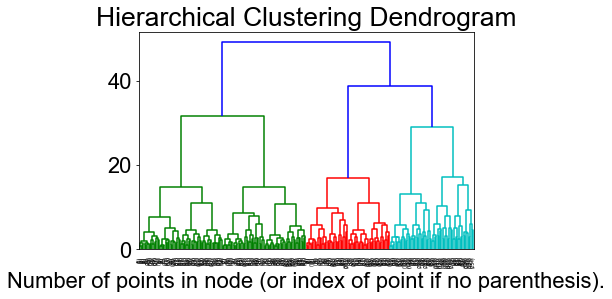

In [186]:
## stole this from scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', compute_full_tree=True)

model = model.fit(X_scaled)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Yeah cool whatever but what does the actual data look like? Well 11 dimensions is damn near impossible to visualize so we can use PCA to help scrunch it down to a dimensional level we can visually process...say 2.

Text(0, 0.5, 'Principal Component 2')

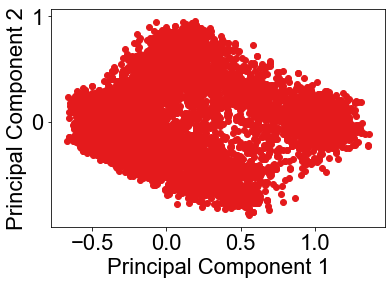

In [187]:
# yeah okay cool chart but how many clusters?
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_scaled)
projected2d = pca.fit_transform(X_scaled)
plt.scatter(x=projected2d[:,0], y=projected2d[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

Is 2 dimensions enough? Check out the plot below. It shows the number of (principal) components necessary to describe the complete data variance. At 2 dimensions we are getting a little more than 70% of the variance explained for us. This is okay.

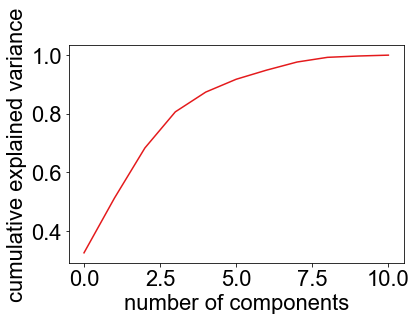

In [188]:
pca = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [189]:
T_df['component1'][0]

-0.32225179373165674

Now that we are okay with such mediocrity, let's take a look at what features are important.

C:\Users\timwi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 154 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\timwi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 154 missing from current font.
  font.set_text(s, 0, flags=flags)


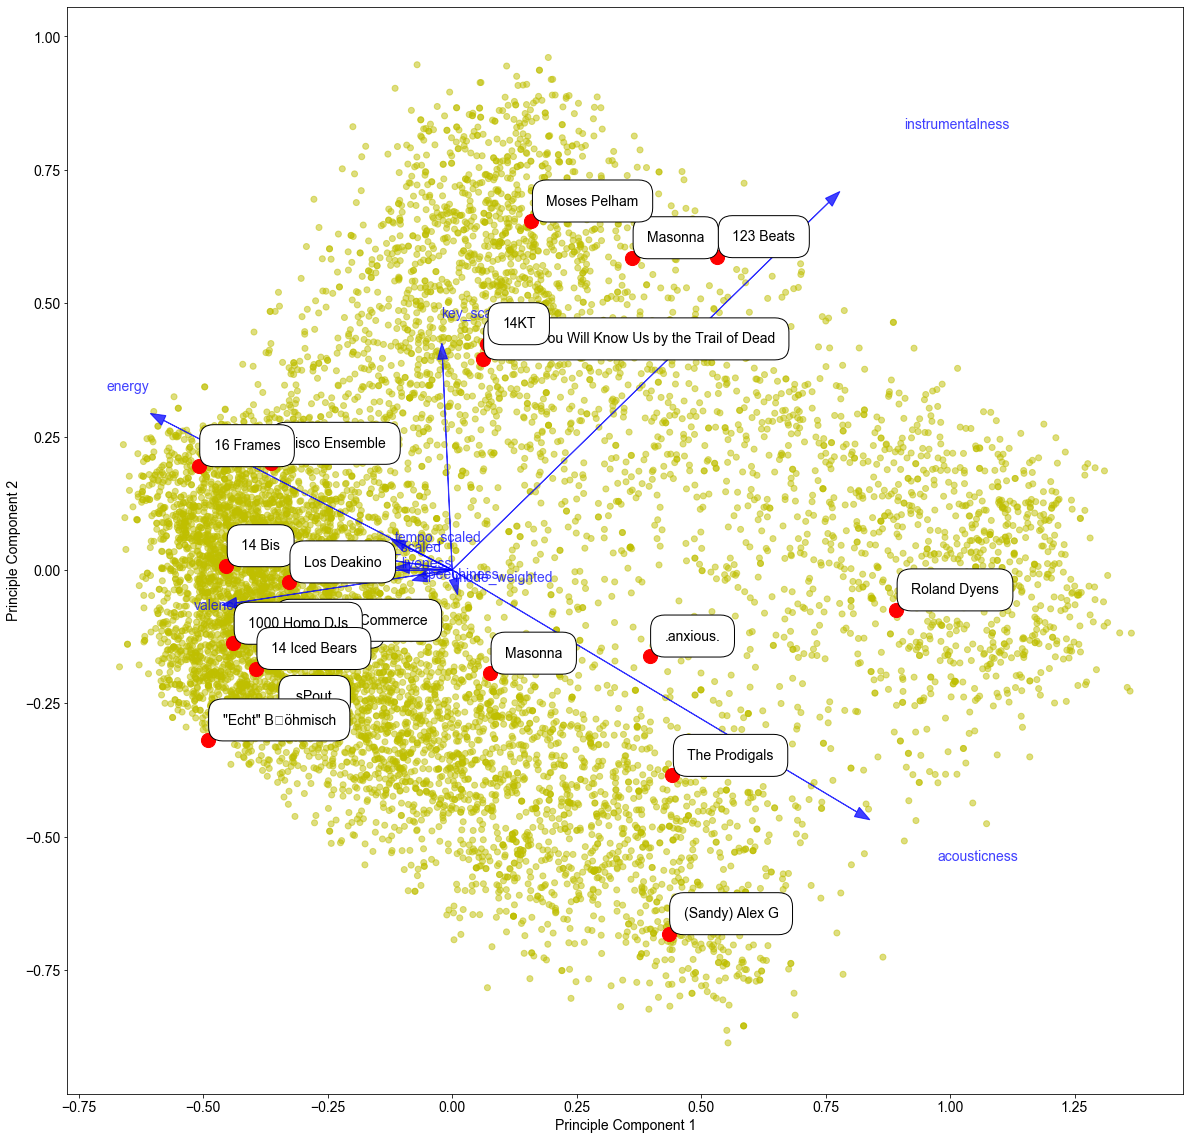

Features by importance:
 [(1.0234122649690298, 'instrumentalness'), (0.9308680581183717, 'acousticness'), (0.6434955271262006, 'energy'), (0.4369910946592752, 'valence'), (0.3956421159638833, 'key_scaled'), (0.21976447050987347, 'danceability'), (0.19530797068177577, 'loudness_scaled'), (0.10601883640350793, 'tempo_scaled'), (0.085705346735286, 'liveness'), (0.05310014900161796, 'speechiness'), (0.017671705018853442, 'mode_weighted')]


In [191]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

def draw_vectors(transformed_features, components_, columns):
    """
    This funtion will project your *original* features
    onto your principal component feature-space, so that you can
    visualize how "important" each one was in the
    multi-dimensional scaling
    """

    num_columns = len(columns)

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])
    plt.figure(figsize=(20,20))
    ax = plt.axes()

    for i in range(num_columns):
    # Use an arrow to project each original feature as a
    # labeled vector on your principal component axes
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.0005, head_width=0.02, alpha=0.75)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(columns)[i], color='b', alpha=0.75)

    return ax

ax = draw_vectors(projected2d, pca.components_, X_scaled.columns.values)
T_df = pd.DataFrame(projected2d)
T_df.columns = ['component1', 'component2']

T_df['color'] = 'y'
T_df.loc[T_df['component1'] > 125, 'color'] = 'g'
T_df.loc[T_df['component2'] > 125, 'color'] = 'r'

plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.scatter(T_df['component1'], T_df['component2'], color=T_df['color'], alpha=0.5)

shifter = 0.03
import random
num_labels = 20
rand_idx = random.sample(range(0, len(X_scaled)), num_labels)
for idx in rand_idx:
    plt.scatter(T_df['component1'][idx], T_df['component2'][idx], marker='o', color='r', s=200)
#     plt.annotate(songs.artist_name[idx], (projected2d[idx,0],projected2d[idx,1]) )
    plt.text(T_df['component1'][idx]+shifter,T_df['component2'][idx]+shifter, songs.artist_name[idx], color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

plt.show()

import math

def get_important_features(transformed_features, components_, columns):
    """
    This function will return the most "important" 
    features so we can determine which have the most
    effect on multi-dimensional scaling
    """
    num_columns = len(columns)

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print( "Features by importance:\n", important_features)

get_important_features(projected2d, pca.components_, X_scaled.columns.values)

Instrumentalness and acousticness are the most important features in our data. Next comes energy, valence (what is valence?). Least important features are speechiness, liveness, and tempo.


The next set of plots shows a way to visualize the appropriateness of your clustering. It is called the silhouette method. You can read more about it [here](https://en.wikipedia.org/wiki/Silhouette_(clustering)). Using this method we want to see well-defined clusters of data in the plots on the right AND higher values of the average silhouette coefficent values (indicated by the dotted vertical red line). Its heuristic but when you're clustering in high dimensions, you're sort of stuck with heuristics. 

array([[0.23562763, 0.15896827, 0.12311035, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [134]:
# cluster, affinity, linkage search
# This search is inefficientAF and will take forever to run.
from sklearn.metrics import silhouette_samples, silhouette_score

cluster_nums = np.arange(2,10000, 100)
affinity = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
linkage = ['complete', 'average', 'single']
score_store = np.zeros((len(affinity) * len(linkage)+1, cluster_nums.shape[0])) #plus one because ward has affinity constraint

X = X_scaled.values
affinity_link = []
for i, aff in enumerate(affinity):
    for j, link in enumerate(linkage):
        affinity_link.append(aff + '_' + link)
        for c, c_num in enumerate(cluster_nums):
            clusterer = AgglomerativeClustering(n_clusters=c_num, affinity=aff, linkage=link)
            cluster_labels = clusterer.fit_predict(X)
            score_store[3*i+j,c] = silhouette_score(X, cluster_labels)
        print(aff + "-" + link + ' done!')
    
affinity_link.append('euclidean' + '_' + 'ward')
for c, cnum in enumerate(cluster_nums):
    clusterer = AgglomerativeClustering(n_clusters=c_num, affinity=aff, linkage=link)
    cluster_labels = clusterer.fit_predict(X)
    score_store[len(affinity) * len(linkage),c] = silhouette_score(X, cluster_labels)        
print('euclidean-ward done!')

                


            
    
        
        
        


euclidean-complete done!
euclidean-average done!
euclidean-single done!
l1-complete done!
l1-average done!
l1-single done!
l2-complete done!
l2-average done!
l2-single done!
manhattan-complete done!
manhattan-average done!
manhattan-single done!
cosine-complete done!
cosine-average done!
cosine-single done!
euclidean-ward done!


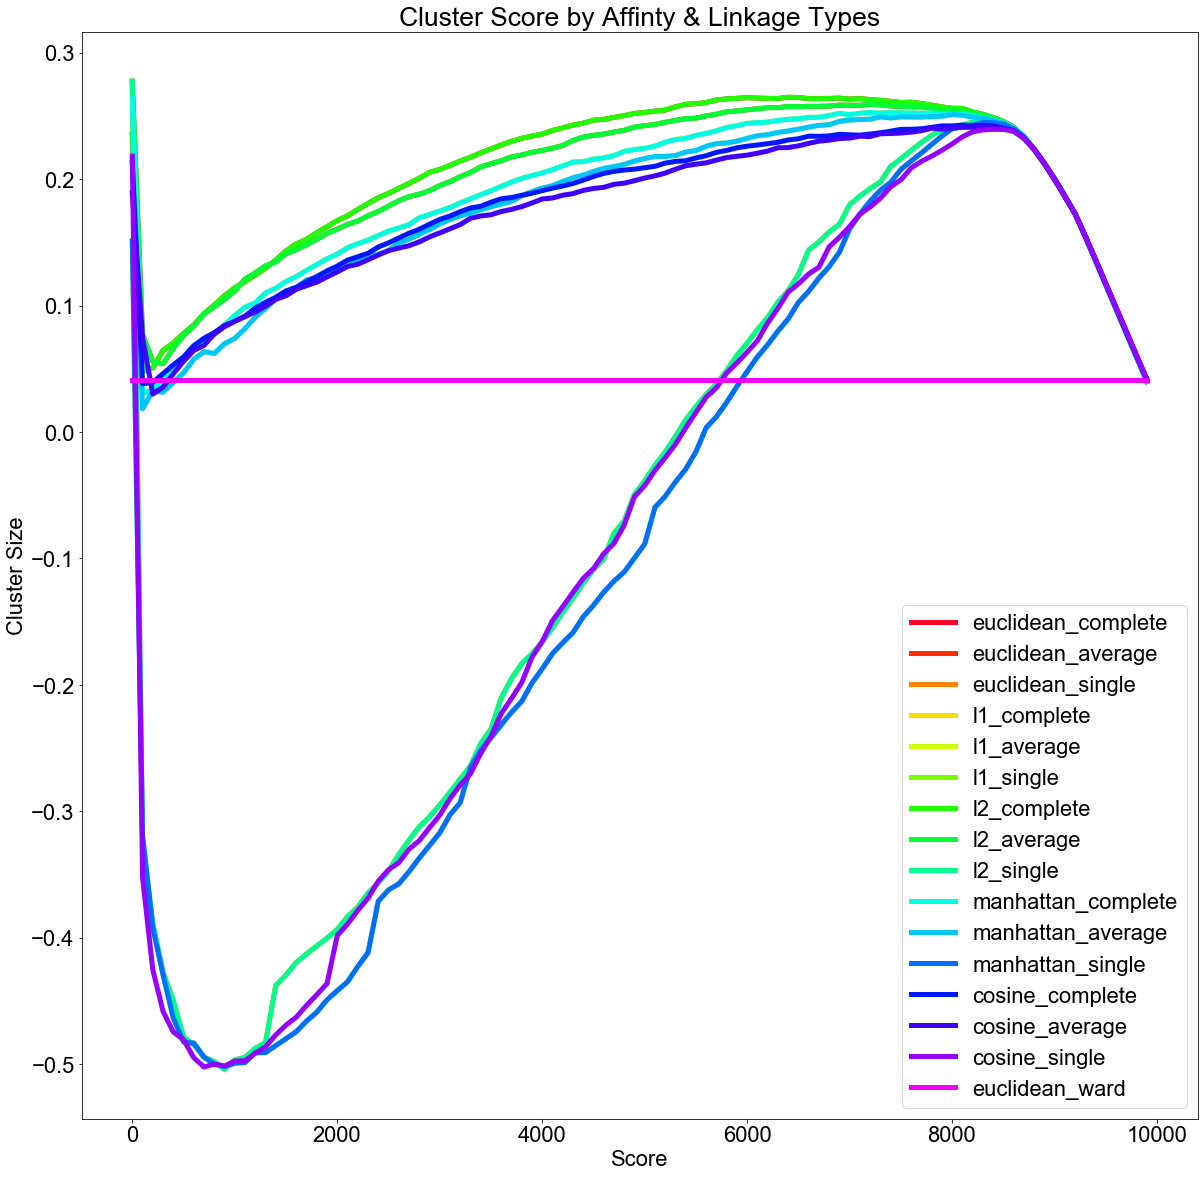

In [139]:
# import matplotlib.pyplot as plt
# # to change default colormap
# plt.rcParams["image.cmap"] = "Set1"
# # to change default color cycle
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

import pylab

NUM_COLORS = 16

cm = pylab.get_cmap('gist_rainbow')
for i in range(NUM_COLORS):
    color = cm(1.*i/NUM_COLORS)  # color will now be an RGBA tuple


score_store_df = pd.DataFrame(score_store)
score_store_df['links'] = affinity_link
score_store_df.iloc[0,:-1]
plt.figure(figsize=(20,20))
plt.legend(affinity_link)
plt.xlabel('Score')
plt.ylabel('Cluster Size')
plt.title('Cluster Score by Affinty & Linkage Types')
for i, afflink in enumerate(affinity_link):
    color = cm(1.*i/NUM_COLORS)
    plt.plot(cluster_nums,(score_store_df.values[i,:-1]).astype(np.float64), label = affinity_link[i], color = color, lw = 5)
plt.legend(loc='lower right')#, bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
score_store_df.to_csv('score_store.csv')
    


For n_clusters = 90 The average silhouette_score is : 0.049443061363874365
For n_clusters = 95 The average silhouette_score is : 0.04901094001824794
For n_clusters = 100 The average silhouette_score is : 0.048641150650323935
For n_clusters = 105 The average silhouette_score is : 0.04439488029617939
For n_clusters = 110 The average silhouette_score is : 0.04394836701115004


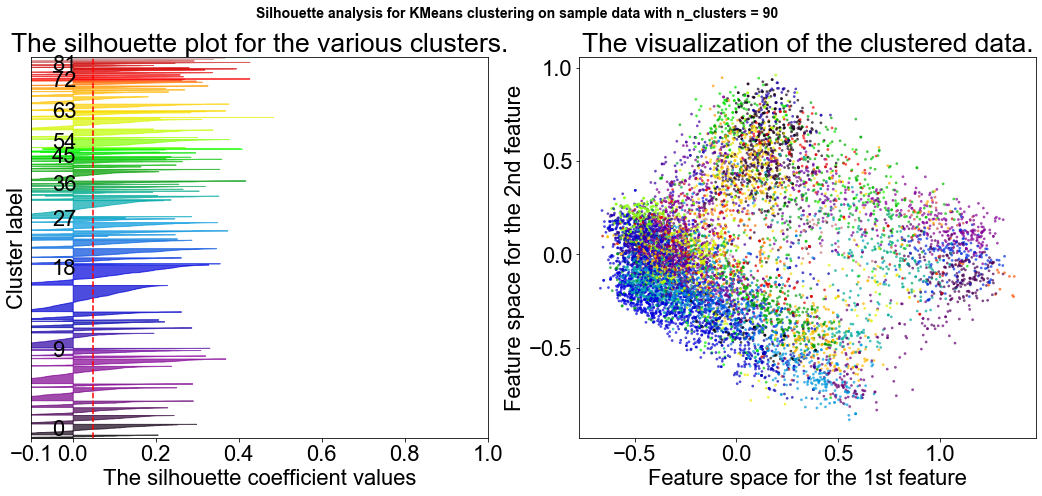

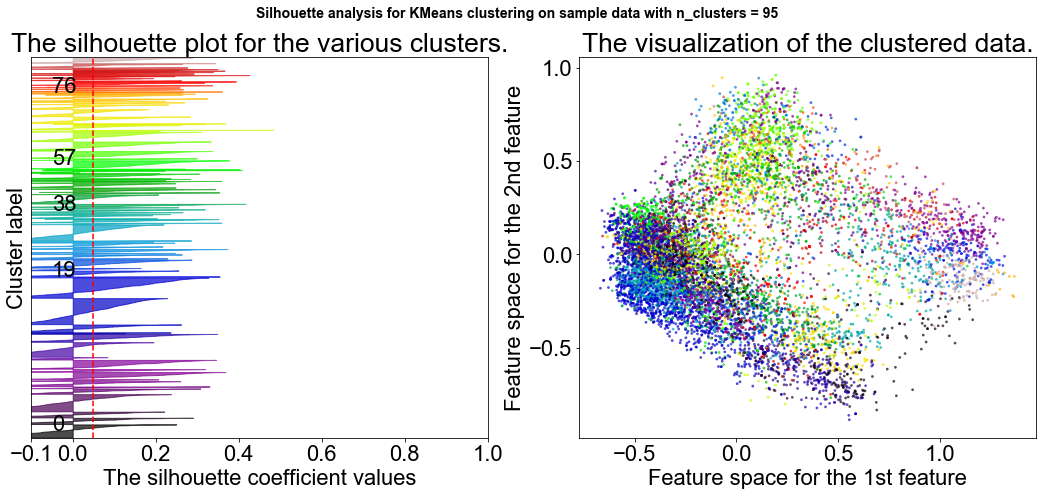

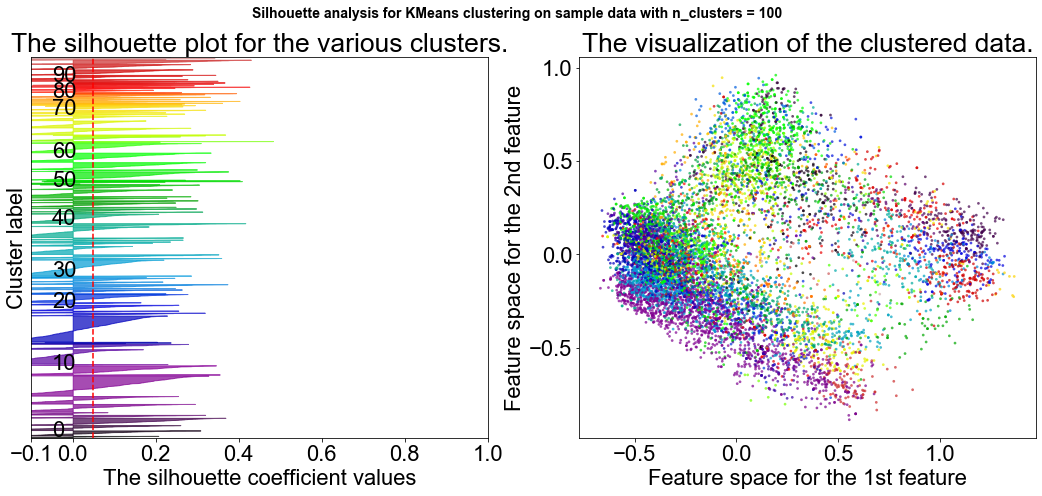

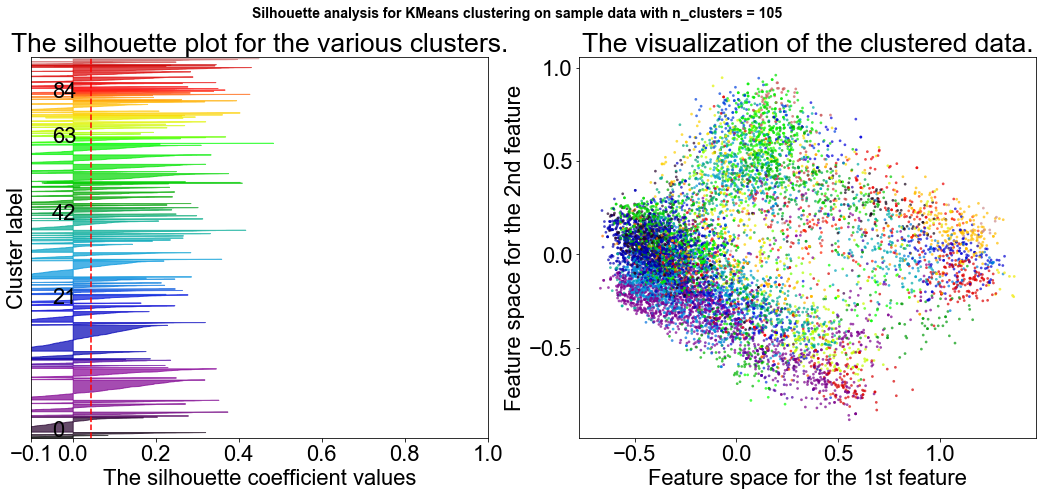

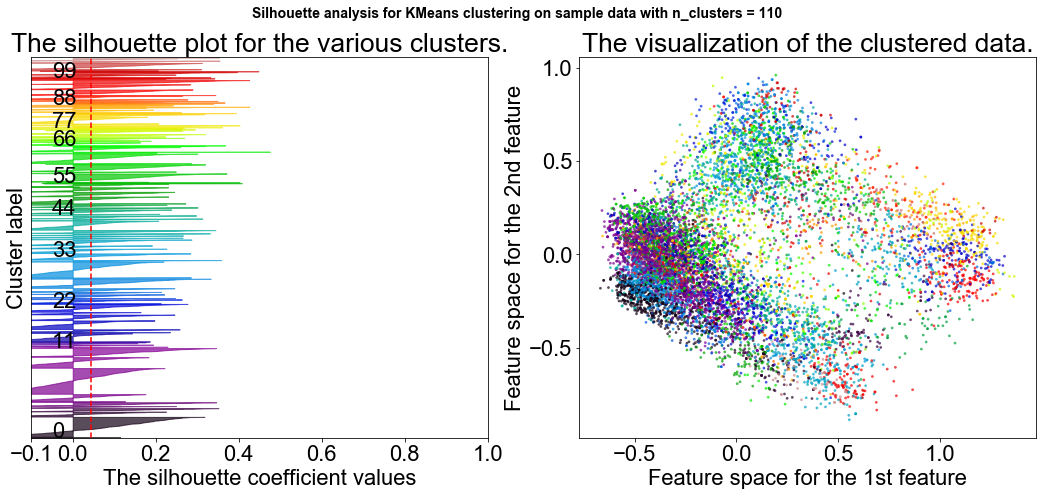

In [147]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
X = X_scaled.values

## Cluster#s by affinity & linkage (score > 0.06):
## Affinity: cosine; Linkage: 'complete' =[2,3,10,33]

range_n_clusters = [90,95,100,105,110]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='l2', linkage='complete')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        n_labels = n_clusters/10 # number of labels to show
        if i % n_labels == 0:
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    
    pca = PCA(2)  # project from 64 to 2 dimensions
    projected = pca.fit_transform(X)


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(projected[:, 0], projected[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = clusterer.labels_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

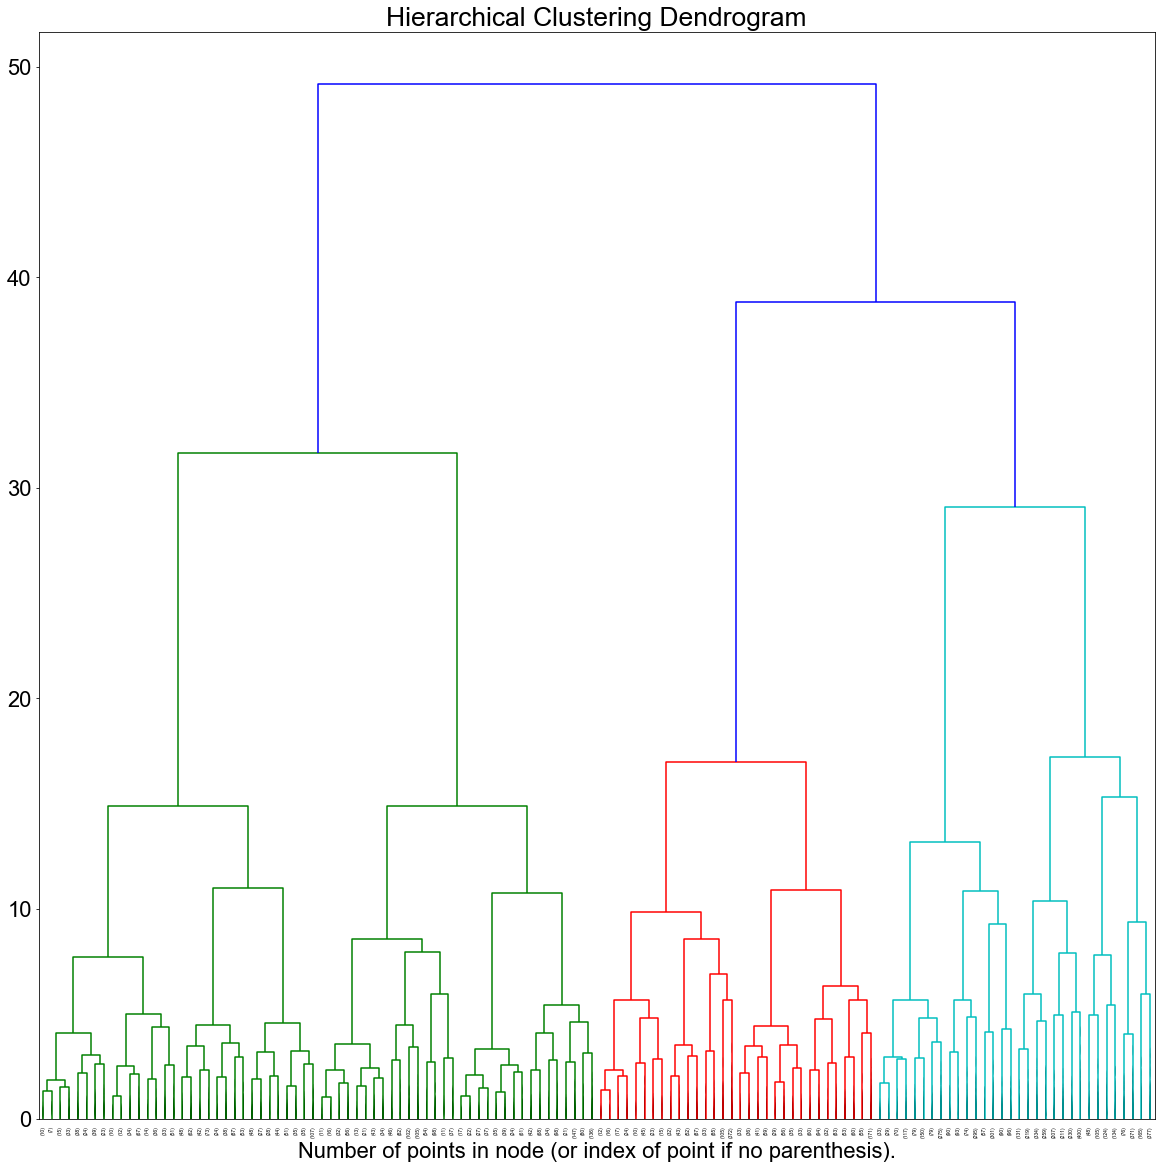

In [153]:
# lets go with n_clusters = 5
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', compute_full_tree=True)

model = model.fit(X_scaled)
plt.figure(figsize=(20,20))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=6, show_contracted=True)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Check out the below. It isn't perfect, for instance there are more major key songs than minor key. Also there are more songs in cluster 21 than any other cluster. This might be an artifact of the data. This may resolve itself when we have more songs to play with.

In [182]:
songs_labeled = pd.concat([songs[info_cols], X_scaled], axis=1)
songs_labeled[songs_labeled.label == 7][["artist_name", "album_name", "label"]].head(10)

,artist_name,album_name,label
11,!!!,Wallop,7
25,!!!,Wallop,7
116,!T.O.O.H.!,Order And Punishment,7
224,!deladap,Made in Mexico (Live from Vive Latino 2013),7
903,#1 80's Club Hits Remixed,"Best of 80's Dance, Vol. 2",7
927,#1 80's Club Hits Remixed,Best Of 80's Dance,7
970,$atori Zoom,Phase 3: Psychosis,7
990,$atori Zoom,Inertia EP,7
1010,$olal,Hôtel Costes 10,7
1170,'68,Two Parts Viper (Deluxe Edition),7


In [166]:
X_scaled

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,loudness_scaled,tempo_scaled,key_scaled,mode_weighted,label
0,0.754,0.635,0.0702,0.03260,0.03370,0.1080,0.4760,0.801953,0.545836,0.545455,0.000000,55
1,0.736,0.924,0.1340,0.00991,0.01050,0.1110,0.7710,0.803751,0.555088,0.090909,0.090909,3
2,0.786,0.724,0.1340,0.01270,0.00472,0.2210,0.3580,0.797723,0.546013,0.636364,0.090909,75
3,0.586,0.817,0.0545,0.05430,0.95700,0.1190,0.1940,0.693208,0.545945,0.181818,0.000000,48
4,0.682,0.886,0.0763,0.00153,0.00028,0.0919,0.6490,0.811313,0.473036,0.363636,0.000000,75
...,...,...,...,...,...,...,...,...,...,...,...,...
10112,0.562,1.000,0.3190,0.01580,0.85900,0.1020,0.0384,0.893035,0.483320,0.454545,0.090909,20
10113,0.681,0.962,0.2180,0.00269,0.77600,0.3360,0.3720,0.883234,0.796002,0.636364,0.090909,88
10114,0.655,0.964,0.3580,0.02720,0.26000,0.2860,0.0860,0.874156,0.796011,0.090909,0.000000,94
10115,0.656,0.960,0.1390,0.03160,0.78100,0.1140,0.1550,0.888910,0.773732,0.363636,0.000000,88


In [192]:
# n_clusters = 100 # multiply this number times 2 -- 1 for each mode
# # clustered_major = AgglomerativeClustering(n_clusters=n_clusters).fit(X_major)
# # X_major['label'] = clustered_major.labels_+n_clusters


# # clustered_minor = AgglomerativeClustering(n_clusters=n_clusters).fit(X_minor)
# # X_minor['label'] = clustered_minor.labels_

# clustered = AgglomerativeClustering(n_clusters=n_clusters).fit(X_scaled)
# X_scaled['label'] = clustered.labels_

# # X_whole = pd.concat([X_major, X_minor])
# plt.figure(figsize=(14,14))
# plt.hist(X_scaled.label, bins=n_clusters*2)
# plt.xlabel('Cluster')
# plt.ylabel('count')
# plt.title('Histogram of clustered songs')
# X_scaled.to_csv('songs_labeled.csv')

# num_clusters = len(list(set(X_scaled.label)))
# cluster_centers = np.zeros((num_clusters, p)) # minus 1 because we removed the mode feature
# for i in range(num_clusters):
#     cluster_centers[i,:] = np.mean(X_scaled[X_scaled.label == i])
# cluster_centers = pd.DataFrame(cluster_centers, columns=X_scaled.columns)
# cluster_centers.label = cluster_centers.label.astype(int)
# cluster_centers

In [193]:
X_scaled

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,loudness_scaled,tempo_scaled,key_scaled,mode_weighted
0,0.754,0.635,0.0702,0.03260,0.03370,0.1080,0.4760,0.801953,0.545836,0.545455,0.000000
1,0.736,0.924,0.1340,0.00991,0.01050,0.1110,0.7710,0.803751,0.555088,0.090909,0.090909
2,0.786,0.724,0.1340,0.01270,0.00472,0.2210,0.3580,0.797723,0.546013,0.636364,0.090909
3,0.586,0.817,0.0545,0.05430,0.95700,0.1190,0.1940,0.693208,0.545945,0.181818,0.000000
4,0.682,0.886,0.0763,0.00153,0.00028,0.0919,0.6490,0.811313,0.473036,0.363636,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
10112,0.562,1.000,0.3190,0.01580,0.85900,0.1020,0.0384,0.893035,0.483320,0.454545,0.090909
10113,0.681,0.962,0.2180,0.00269,0.77600,0.3360,0.3720,0.883234,0.796002,0.636364,0.090909
10114,0.655,0.964,0.3580,0.02720,0.26000,0.2860,0.0860,0.874156,0.796011,0.090909,0.000000
10115,0.656,0.960,0.1390,0.03160,0.78100,0.1140,0.1550,0.888910,0.773732,0.363636,0.000000
